In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt

In [2]:
!pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import seaborn as sns
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
# perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240710/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_cls_hybrid_attn_fnn_2l_lr1e-4/aligned_msl256_s64/processed/tl_tf_multi_coronaviridae_s_uniprot_sars_cov_2_aligned.csv_WIV04.csv")
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240728/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/aligned_msl256cls_s64_vs30/processed/tl_tf_multi_coronaviridae_s_uniprot_sars_cov_2_aligned.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    return df

In [7]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [8]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [9]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)



#### WIV04 reference sequence

In [10]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/alignment/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [11]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2121


'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [12]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [13]:
perturbed_output_df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.121057,0.002247,0.000055,0.003453,0.001354,0.870139,0.001656,0.000040,WIV04,Human,V,126,A,0.000065,0.000065,Human,Human,62
1,0.121070,0.002253,0.000055,0.003456,0.001356,0.870115,0.001656,0.000040,WIV04,Human,F,156,R,0.000040,0.000040,Human,Human,92
2,0.121099,0.002257,0.000055,0.003459,0.001357,0.870076,0.001658,0.000040,WIV04,Human,V,1438,H,0.000001,0.000001,Human,Human,736
3,0.114113,0.001755,0.000040,0.002856,0.001059,0.878794,0.001356,0.000027,WIV04,Human,L,196,H,0.008719,0.008719,Human,Human,117
4,0.121074,0.002254,0.000055,0.003456,0.001356,0.870109,0.001656,0.000040,WIV04,Human,F,123,B,0.000035,0.000035,Human,Human,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,0.121035,0.002253,0.000055,0.003452,0.001355,0.870156,0.001655,0.000040,WIV04,Human,K,1435,E,0.000082,0.000082,Human,Human,733
31822,0.120850,0.002241,0.000054,0.003433,0.001347,0.870390,0.001645,0.000040,WIV04,Human,L,1327,Q,0.000315,0.000315,Human,Human,650
31823,0.120983,0.002250,0.000054,0.003445,0.001352,0.870225,0.001651,0.000040,WIV04,Human,L,1158,N,0.000150,0.000150,Human,Human,560
31824,0.120884,0.002226,0.000054,0.003433,0.001343,0.870374,0.001646,0.000040,WIV04,Human,R,1790,Z,0.000300,0.000300,Human,Human,1019


In [14]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [15]:
perturbed_output_df[perturbed_output_df["perturb_seq_pos"]==493]

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
2849,0.121100,0.002256,0.000055,0.003458,0.001357,0.870075,0.001658,0.00004,WIV04,Human,Q,1057,F,1.160000e-06,1.160000e-06,Human,Human,493
2948,0.121098,0.002256,0.000055,0.003458,0.001357,0.870078,0.001658,0.00004,WIV04,Human,Q,1057,K,3.800000e-06,3.800000e-06,Human,Human,493
4041,0.121100,0.002256,0.000055,0.003458,0.001357,0.870075,0.001658,0.00004,WIV04,Human,Q,1057,Z,4.500000e-07,4.500000e-07,Human,Human,493
4351,0.121099,0.002256,0.000055,0.003458,0.001357,0.870076,0.001658,0.00004,WIV04,Human,Q,1057,M,1.760000e-06,1.760000e-06,Human,Human,493
4883,0.121099,0.002256,0.000055,0.003458,0.001357,0.870076,0.001658,0.00004,WIV04,Human,Q,1057,C,1.400000e-06,1.400000e-06,Human,Human,493
5802,0.121100,0.002256,0.000055,0.003458,0.001357,0.870075,0.001658,0.00004,WIV04,Human,Q,1057,U,3.000000e-07,3.000000e-07,Human,Human,493
6232,0.121102,0.002256,0.000055,0.003459,0.001357,0.870073,0.001658,0.00004,WIV04,Human,Q,1057,A,-1.400000e-06,1.400000e-06,Human,Human,493
6946,0.121100,0.002256,0.000055,0.003458,0.001357,0.870075,0.001658,0.00004,WIV04,Human,Q,1057,O,3.000000e-07,3.000000e-07,Human,Human,493
9167,0.121099,0.002257,0.000055,0.003458,0.001357,0.870076,0.001658,0.00004,WIV04,Human,Q,1057,L,1.700000e-06,1.700000e-06,Human,Human,493
9257,0.121099,0.002256,0.000055,0.003458,0.001357,0.870076,0.001658,0.00004,WIV04,Human,Q,1057,V,1.500000e-06,1.500000e-06,Human,Human,493


# Overview

### Distribution of Human class difference

In [16]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [17]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 5 (0.01571042543832087)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.529022 -0.499844      1    0.003142
1  -0.499844 -0.470667      0    0.000000
2  -0.470667 -0.441490      0    0.000000
3  -0.441490 -0.412313      1    0.003142
4  -0.412313 -0.383136      0    0.000000
5  -0.383136 -0.353958      0    0.000000
6  -0.353958 -0.324781      0    0.000000
7  -0.324781 -0.295604      0    0.000000
8  -0.295604 -0.266427      0    0.000000
9  -0.266427 -0.237250      0    0.000000
10 -0.237250 -0.208072      0    0.000000
11 -0.208072 -0.178895      0    0.000000
12 -0.178895 -0.149718      0    0.000000
13 -0.149718 -0.120541      3    0.009426
14 -0.120541 -0.091364      0    0.000000
15 -0.091364 -0.062186      6    0.018853
16 -0.062186 -0.033009     73    0.229372
17 -0.033009 -0.003832    747    2.347138
18 -0.003832  0.025345  30989   97.370075
19  0.025345  0.054522      6    0

<Figure size 432x288 with 0 Axes>

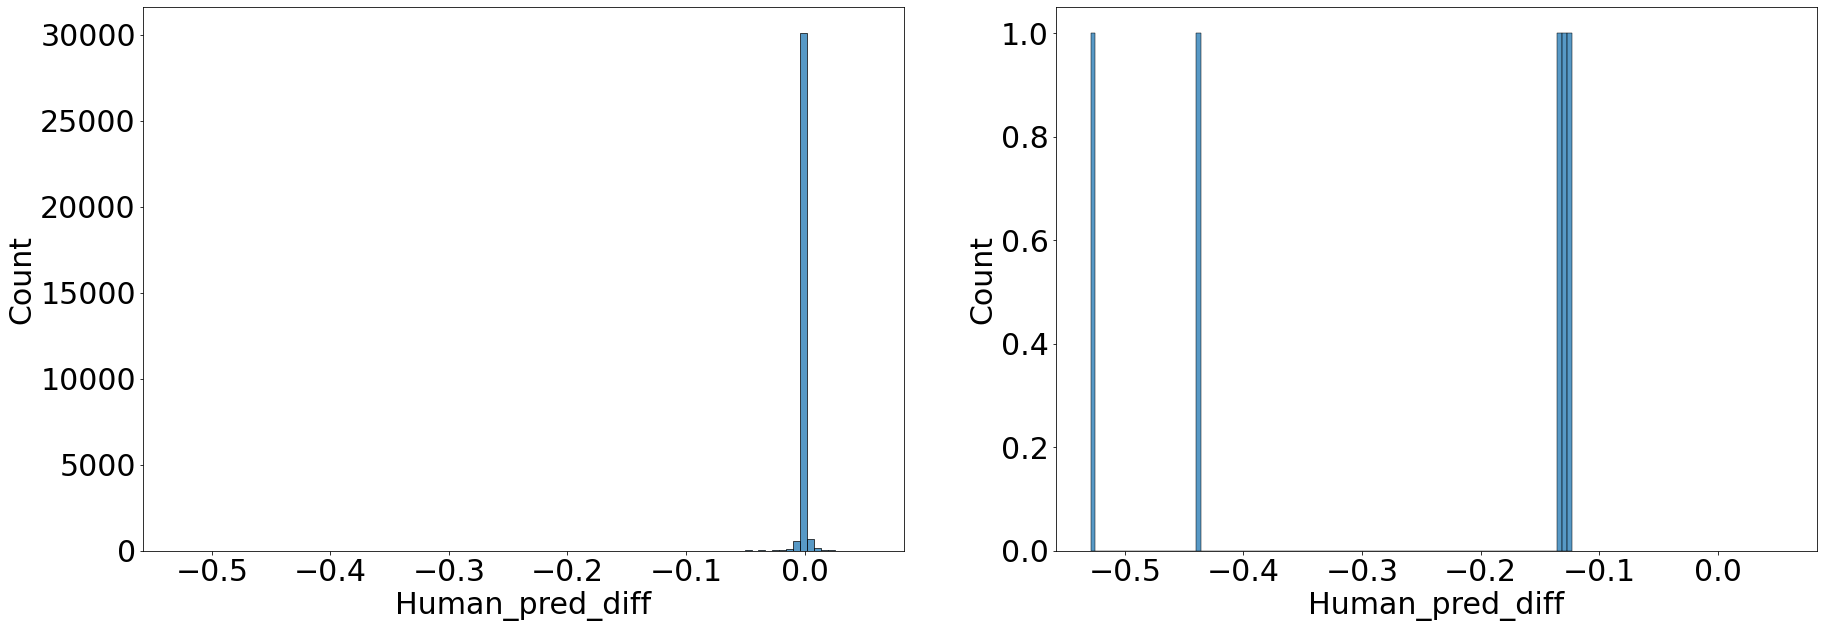

In [18]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

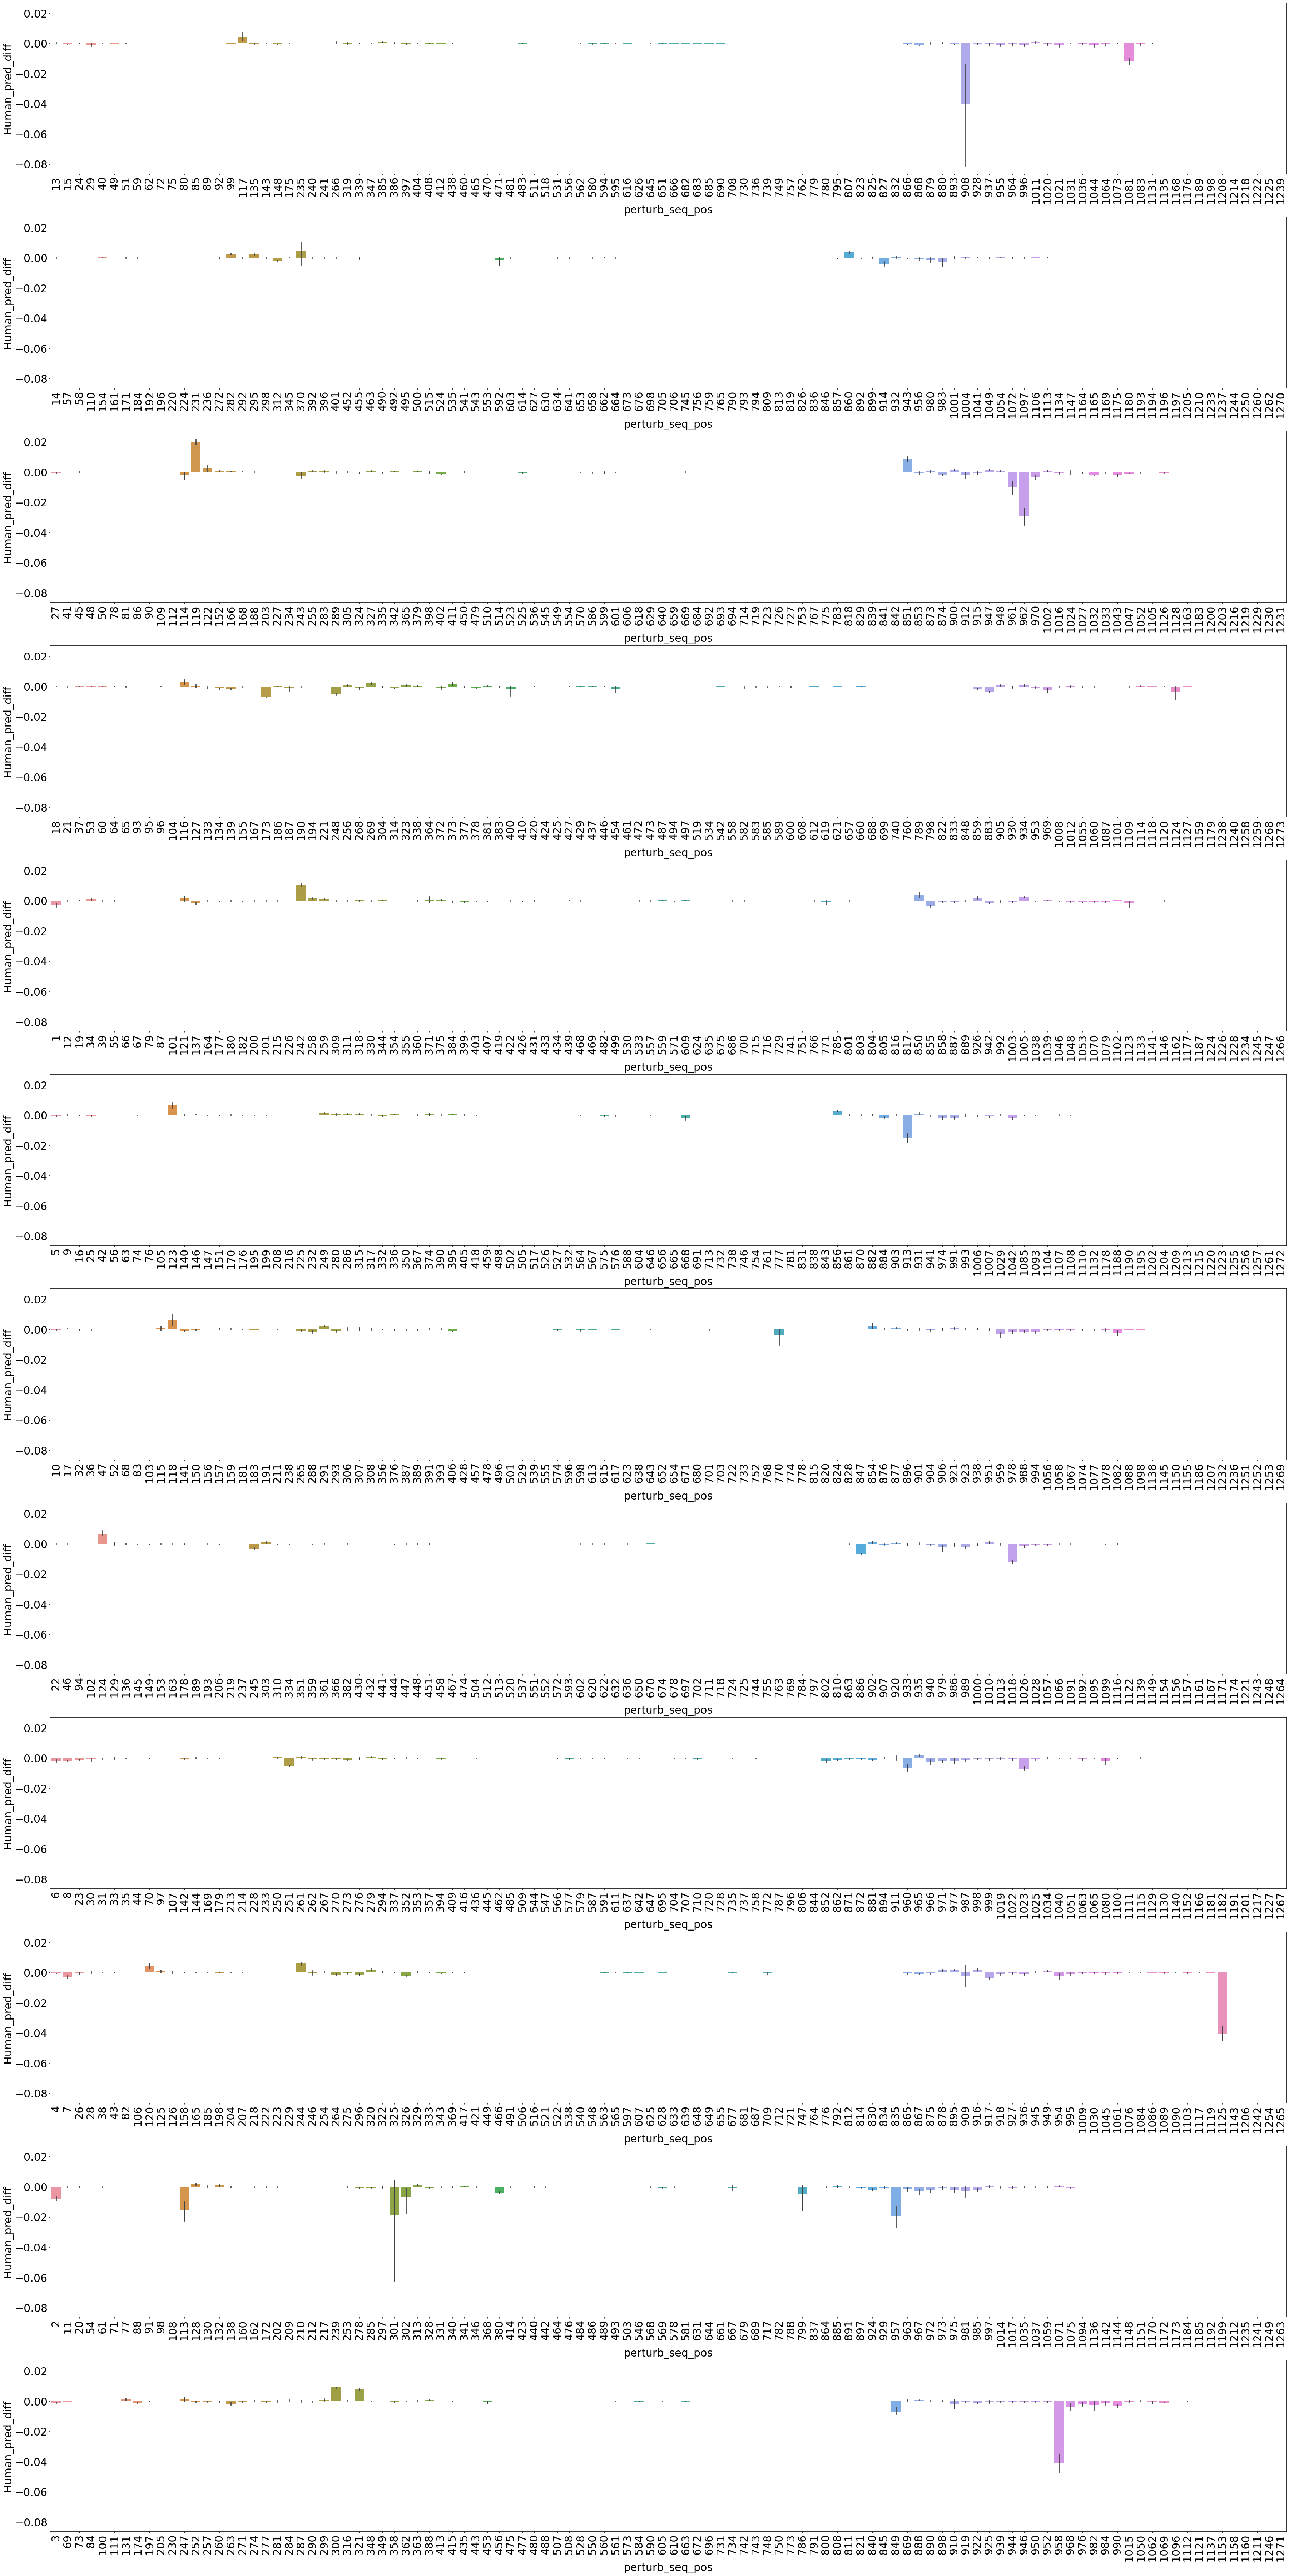

In [19]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 12
fig, axs = plt.subplots(n, 1, figsize=(50, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbed_output_df["perturb_seq_pos"].unique()), n)

for i in range(n):
    sns.barplot(perturbed_output_df[perturbed_output_df["perturb_seq_pos"].isin(bins[i])], x="perturb_seq_pos", y=pred_diff_col, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: mean=0 and variance=0

In [20]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
len(cut_off_pos_1)


1264

In [ ]:
plt.clf()
n = 27
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(n, 1, figsize=(30, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(cut_off_pos_1), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_1[cut_off_df_1["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [ ]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

In [ ]:
plt.clf()
n = 1
fig, axs = plt.subplots(n, 1, figsize=(20, 5), sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), n)

for i in range(1):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs, orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs.tick_params(axis='x', rotation=90)
    axs.axhline(0.0, color="gray", linestyle="--")

plt.show()


## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [ ]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

In [ ]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [ ]:
annotate_df

### Mutations with new token NOT = X

In [ ]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

In [ ]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [ ]:
cut_off_df_2["perturbation_id"].nunique()

In [ ]:
plt.clf()
n = 1
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(n, 1, figsize=(30, 10), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), n)

for i in range(n):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs, orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs.tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [ ]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_grouped_filtered.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
#s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

In [ ]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

In [ ]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["spike_mutations"])]

# s_mutations_df = s_mutations_df.merge(known_mutations_df[["perturbation_id", "label"]], on="perturbation_id")
# s_mutations_df

In [ ]:
plt.clf()
plt.figure(figsize=(70, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="perturbation_id", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["perturbation_id"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [ ]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["spike_mutations"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))